In [3]:
from Bio import Entrez
import io
from Bio import SeqIO
import pandas as pd
import os
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt

__author__ = 'Natalia Quinones-Olvera'
__email__ = "nquinones@g.harvard.edu"
Entrez.email = __email__

# GeneViking - protoype class

`NCBIQuery(acc, start, end, thresh)`
- `download_gb(output=None)`
- `parse_gb(self, file=None, output=None)`
- `download_fasta(self, output=None)`
- `prokka_table(self, direc, output=None)`

In [14]:
class NCBIQuery:
    
    def __init__(self, acc, start, end, thresh):
        
        # ncbi accession
        self.acc = acc
        
        # range
        self.query_range = set(range(start, end))

        self.start = start
        self.end = end
        
        # neighborhood
        self.rangeend = end + thresh
        self.rangestart = start - thresh
        
        if self.rangestart < 0:
            self.rangestart = 0
            
    
    def __parse_loc(self, loc, ref_start):
        '''
        Function to parse the location object
        of Biopython's .gb parser.
        '''
        
        # start
        if str(type(loc.start)) == "<class 'Bio.SeqFeature.ExactPosition'>":
            start = loc.start + ref_start
            start_str = start
        elif str(type(loc.start)) == "<class 'Bio.SeqFeature.BeforePosition'>":
            start = loc.start + ref_start
            start_str = '<' + str(start)
        elif str(type(loc.start)) == "<class 'Bio.SeqFeature.AfterPosition'>":
            start = loc.start + ref_start
            start_str = '>' + str(start)
        else:
            start_str = 'unknown position type'

        # end
        if str(type(loc.end)) == "<class 'Bio.SeqFeature.ExactPosition'>":
            end = loc.end + ref_start - 1
            end_str = end
        elif str(type(loc.end)) == "<class 'Bio.SeqFeature.BeforePosition'>":
            end = loc.end + ref_start - 1 
            end_str = '<' + str(end)
        elif str(type(loc.end)) == "<class 'Bio.SeqFeature.AfterPosition'>":
            end = loc.end + ref_start -1
            end_str = '>' + str(end)
        else:
            end_str = 'unknown position type'

        if loc.strand == 1:
            strand = '+'
        else:
            strand = '-'

        return [start, end, start_str, end_str, strand]
    
    
    def download_gb(self, output=None):
        '''
        Requests genbank file with Entrez
        '''
        
        epost = Entrez.epost('nuccore', id=self.acc)
        request = Entrez.read(epost)

        response = Entrez.efetch(db='nuccore',
                                 webenv=request['WebEnv'],
                                 query_key=request['QueryKey'],
                                 rettype='gb',
                                 retmode="text",
                                 seq_start=self.rangestart,
                                 seq_stop=self.rangeend)

        response_io = io.StringIO(response.read())
        
        if output:
            for record in SeqIO.parse(response_io, 'genbank'):
                genbank_records = record
            
            SeqIO.write(genbank_records, output, 'genbank')
        
        return response_io
        
    
    def parse_gb(self, file=None, output=None):
        '''
        Parse gb file. Extracts product information from
        feature types: CDS, tRNA, rRNA, ncRNA, and repeat_region
        and writes dataframe with output.
        Can save table into tsv output
        '''
        
        if file:
            gbfile = file
            
        else:
            gbfile = self.download_gb()
        
        feats = []

        for record in SeqIO.parse(gbfile, 'genbank'):
            for feat in record.features:
                # extract location object
                fstart, fend, fstart_str, fend_str, fstrand = self.__parse_loc(feat.location, self.rangestart)
                # save range
                feat_range = set(range(fstart, fend))

                # check overlap
                if len(self.query_range.intersection(feat_range)) == 0:
                    status = ''
                else:
                    status = '!'


                if feat.type == 'CDS':
                    if 'pseudo' not in feat.qualifiers:
                        prot_id = feat.qualifiers['protein_id'][0]
                        product = feat.qualifiers['product'][0]

                        feat_info = [feat.type, prot_id, product, fstart_str, fend_str, fstrand, status]

                    else:
                        prot_id = 'None'
                        product = feat.qualifiers['product'][0]

                        feat_info = ['CDS_pseudo', prot_id, product, fstart_str, fend_str, fstrand, status]

                    feats.append(feat_info)

                if feat.type in ['tRNA', 'rRNA', 'ncRNA', 'repeat_region']:
                    product = feat.qualifiers['product'][0]

                    feat_info = [feat.type, None, product, fstart_str, fend_str, fstrand, status]
                    
                    feats.append(feat_info)

        df = pd.DataFrame(feats)
        
        df.columns = ['type', 'acc', 'product', 'start', 'end', 'strand', 'query_overlap']

        if output is not None:
            df.to_csv(output, sep='\t', index=None)

        return df
    
    def download_fasta(self, output=None):
        '''
        Requests fasta file with Entrez
        '''
        epost = Entrez.epost('nuccore', id=self.acc)
        request = Entrez.read(epost)

        response = Entrez.efetch(db='nuccore',
                                 webenv=request['WebEnv'],
                                 query_key=request['QueryKey'],
                                 rettype='fasta',
                                 retmode="text",
                                 seq_start=self.rangestart,
                                 seq_stop=self.rangeend)

        response_io = io.StringIO(response.read())
        
        if output:
            for record in SeqIO.parse(response_io, 'fasta'):
                fasta_records = record
            
            SeqIO.write(fasta_records, output, 'fasta')
        
        return response_io
    
    def prokka_table(self, direc, output=None):
        '''
        '''
        
        # download fasta
        fasta_dwn = self.download_fasta()
        
        for record in SeqIO.parse(fasta_dwn, 'fasta'):
                fastarecord = record
        
        # fetch name
        name = '{}.fa'.format(fastarecord.id.replace(':', '_'))
        
        fasta_out = os.path.join(direc, name)

        # check if directory exists
        if not os.path.exists(direc):
            os.makedirs(direc)
        
        # save fasta file
        if not os.path.exists(fasta_out):
            SeqIO.write(fastarecord, fasta_out, 'fasta')
        else:
            print('ERROR: File {} already exists.'.format(fasta_out))
            
        # prokka
        prokka_dir = os.path.join(direc, 'prokka/{}'.format(name))
        
        process = subprocess.run(['prokka',
                                  '--outdir', prokka_dir,
                                  '--prefix', name,
                                  '--hmms', '/Users/nquinones/biosoft/Pfam-31.0/Pfam-A.hmm',
                                  '--compliant',
                                  fasta_out],
                                 stdout=subprocess.PIPE,
                                 stderr=subprocess.PIPE,
                                 universal_newlines=True)
        
        if process.returncode != 0:
            print('ERROR: {} \n {}'.format(process.returncode, process.stderr))
        else:
            #print('Done. Saved in: {}'.format(prokka_dir))
            
            gbk_path = '{}/{}.gbk'.format(prokka_dir, name)
            
            df = self.parse_gb(file=gbk_path, output=output)
            
            return df

# Viking - protoype class

In [419]:
import time

In [17]:
class Viking:
    
    def __init__(self, entries):
        
        self.entries = entries
        
        if not type(self.entries) == list:
            raise ValueError('entries should be a list of NCBIQuery objects')
        
        for entry in self.entries:
            if not isinstance(entry, NCBIQuery):
                raise ValueError('entries should be a list of NCBIQuery objects')
    
    def batch_gb(self):
        '''
        '''
        df_list = []
        
        for query in self.entries:
            gb_table = query.parse_gb()
            df_list.append(gb_table)
            
        df = pd.concat(df_list)
            
        return df
    
    def gb_heatmap(self, heatmap=True):
        
        df_list = []
        
        for query in self.entries:
            try:
                gb_table = query.parse_gb()
            except:
                print(query.acc)
             
            gb_table['genome_acc'] = [query.acc] * len(gb_table)
            gb_table['presence'] = [1] * len(gb_table)
            df_list.append(gb_table)
            
            time.sleep(2)
            
        df = pd.concat(df_list)
        
        df_pa = pd.pivot_table(df,
                               values='presence',
                               index=['product'],
                               columns='genome_acc')
        
        df_pa = df_pa.fillna(0)
        
        if heatmap:
            width = 1 * len(df_list)
            
            cm = sns.clustermap(df_pa, cmap='Blues', cbar=False, linewidths=.01)
            cm.cax.set_visible(False)
            plt.figure(figsize=(width, 30))
            
            
        return df_pa
    
    def prokka_heatmap(self, heatmap=True):
        
        df_list = []
        
        for query in self.entries:
            gb_table = query.prokka_table('ggg2')
             
            gb_table['genome_acc'] = [query.acc] * len(gb_table)
            gb_table['presence'] = [1] * len(gb_table)
            df_list.append(gb_table)
            
            #time.sleep(2)
            
        df = pd.concat(df_list)
        
        df_pa = pd.pivot_table(df,
                               values='presence',
                               index=['product'],
                               columns='genome_acc')
        
        df_pa = df_pa.fillna(0)
        
        if heatmap:
            width = 1 * len(df_list)
            
            cm = sns.clustermap(df_pa, cmap='Blues', cbar=False, linewidths=.01)
            cm.cax.set_visible(False)
            plt.figure(figsize=(width, 30))
            
            
        return df_pa

In [9]:
def input_tsv(tsv, threshold):
    
    df = pd.read_csv(tsv, delim_whitespace=True, header=None)
    df.columns = ['acc', 'start', 'end']
    
    viking_list = []
    
    for row, index in df.iterrows():
        viking_list.append(NCBIQuery(index['acc'], index['start'], index['end'], threshold))
    
    
    return Viking(viking_list)

In [11]:
test = input_tsv('untitled.txt', 20000)

genome_acc,AP010958.1,AP012273.1,AP014690.1,AP014856.1,AP017617.1,AP017620.1,AP018786.1,AP018827.1,CP000076.1,CP000319.1,...,CP030923.1,FN649414.1,FO834906.1,FQ859181.1,LK931336.1,LM997002.1,LO017727.1,LS483392.1,LT629747.1,LT707061.1
product,,,,,,,,,,,,,,,,,,,,,
"1,2-epoxyphenylacetyl-CoA isomerase",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-deoxy-D-xylulose 5-phosphate reductoisomerase,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 kDa chaperonin 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15-cis-phytoene desaturase,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1D-myo-inositol 2-acetamido-2-deoxy-alpha-D-glucopyranoside deacetylase,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2,3,4,5-tetrahydropyridine-2,6-dicarboxylate N-acetyltransferase",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-aminomuconate deaminase,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2-succinyl-6-hydroxy-2, 4-cyclohexadiene-1-carboxylate synthase",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23S rRNA (guanosine-2'-O-)-methyltransferase RlmB,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


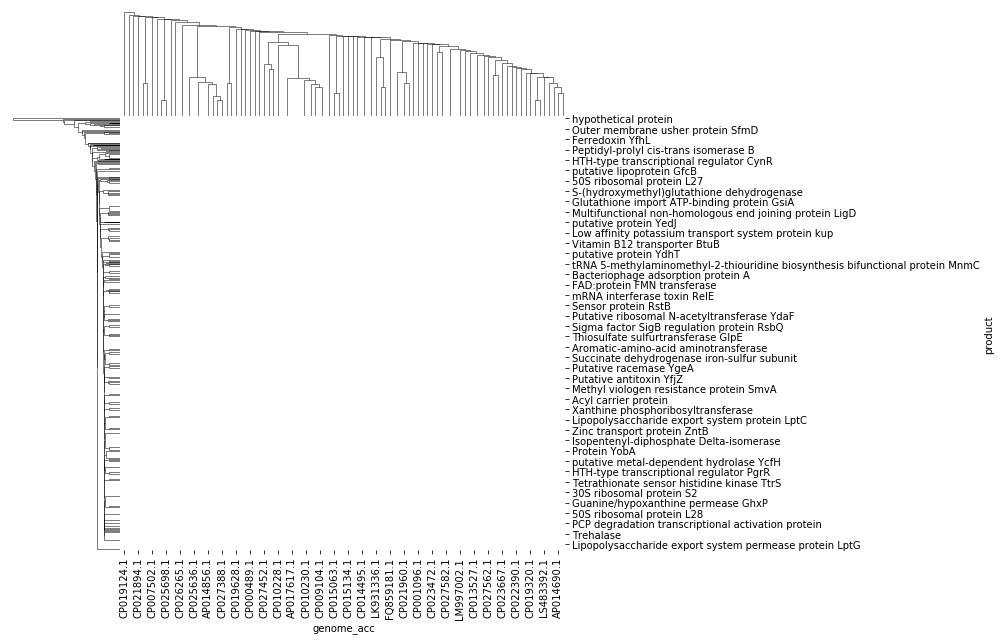

<Figure size 6840x2160 with 0 Axes>

In [12]:
test.prokka_heatmap()

In [18]:
test = input_tsv('untitled.txt', 20000)

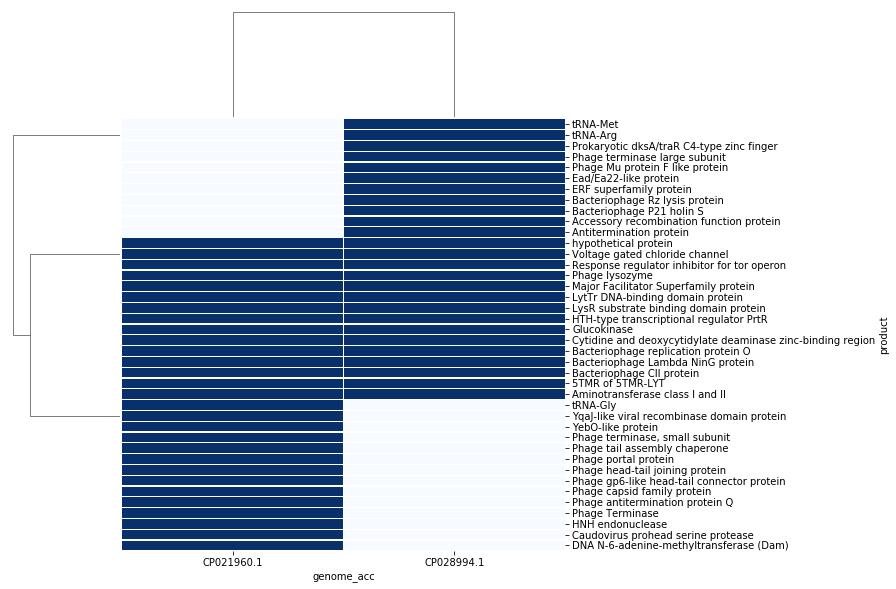

<Figure size 144x2160 with 0 Axes>

In [19]:
df = test.prokka_heatmap()